<a href="https://colab.research.google.com/github/maryam-sabet/TransferLearning_BinaryCNNModel/blob/main/TransferLearning_simpleCNNmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**"The provided code demonstrates the process of building a Convolutional Neural Network (CNN) for binary image classification. It involves loading and preprocessing images, extracting features using a pre-trained Xception model, and training a custom CNN model on the extracted features. The model is evaluated for its performance in distinguishing between Epileptic and Normal images."**

# **Libraries**

In [3]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers


# **Loading data**

In [ ]:
# Load a sample image
im = cv2.imread('DataspectrogramEEG/New folder/Epileptic/e1.jpg')
print(im.shape)
print(type(im.shape))

In [ ]:
# Define labels for the dataset
Epileptic_Labels = np.zeros(100)
print(Epileptic_Labels)

In [ ]:
Normal_Labels = np.ones(198)
print(Normal_Labels)

In [ ]:
# Combine Epileptic and Normal labels
Labels = np.append(Epileptic_Labels, Normal_Labels)
print(Labels)

In [ ]:
np.save('Labels.npy', Labels)

In [ ]:
# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [ ]:
Epileptic_data =  load_images_from_folder("DataspectrogramEEG/New folder/Epileptic")
Normal_data =  load_images_from_folder("DataspectrogramEEG/New folder/Normal")

# **Train/Test split**

In [ ]:
from sklearn.model_selection import train_test_split
Epileptic_x_train,Epileptic_x_test,Epileptic_y_train,Epileptic_y_test=train_test_split(Epileptic_data,Epileptic_Labels,test_size=0.23)

In [ ]:
from sklearn.model_selection import train_test_split
Normal_x_train,Normal_x_test,Normal_y_train,Normal_y_test=train_test_split(Normal_data,Normal_Labels,test_size=0.23)

In [ ]:
# Concatenate the data for training and testing
train_y=np.concatenate((np.asarray(Epileptic_y_train) , np.asarray(Normal_y_train)), axis=0)
train_x=np.concatenate((np.asarray(Epileptic_x_train) , np.asarray(Normal_x_train)), axis=0)
test_x=np.concatenate((np.asarray(Epileptic_x_test) , np.asarray(Normal_x_test)), axis=0)
test_y=np.concatenate((np.asarray(Epileptic_y_test) , np.asarray(Normal_y_test)), axis=0)

In [ ]:
train_x.shape

# **PreTrain Model**

In [ ]:
# Load a pre-trained convolutional Xception model trained on imagenet weights
conv_base = keras.applications.xception.Xception(weights="imagenet",include_top=False,input_shape=(420,560,3))
conv_base.summary()

In [ ]:
# Preprocess and extract features from images using the convolutional Xception model
preprocessed_images = keras.applications.xception.preprocess_input(tensorflow.cast(tensorflow.expand_dims(train_x[1], 0),dtype=float))
preprocessed_images.shape

In [ ]:
# Function to extract features and labels from a dataset
def get_features_and_labels(dataset):
   all_features = []
   for i in range(dataset.shape[0]):
       preprocessed_images = keras.applications.xception.preprocess_input(tensorflow.expand_dims(dataset[i], 0))
       features = conv_base.predict(preprocessed_images)
       all_features.append(features)

   return np.concatenate(all_features)

# Extract features from training and testing images
train_features= get_features_and_labels(tensorflow.cast(train_x,dtype=float))
test_features = get_features_and_labels(tensorflow.cast(test_x,dtype=float))

In [ ]:
test_features.shape

# **CNN Binary Classification Model**


In [ ]:
# Build a binary classification model on top of the pre-trained features
inputs = keras.Input(shape=(13, 18, 2048))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy",keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.SensitivityAtSpecificity(0.5)])

In [ ]:
# Train the model
history = model.fit(train_features, train_y, epochs=20)

In [ ]:
# Evaluate the model on the test data
test_evaluate = model.evaluate(test_features,test_y)

# 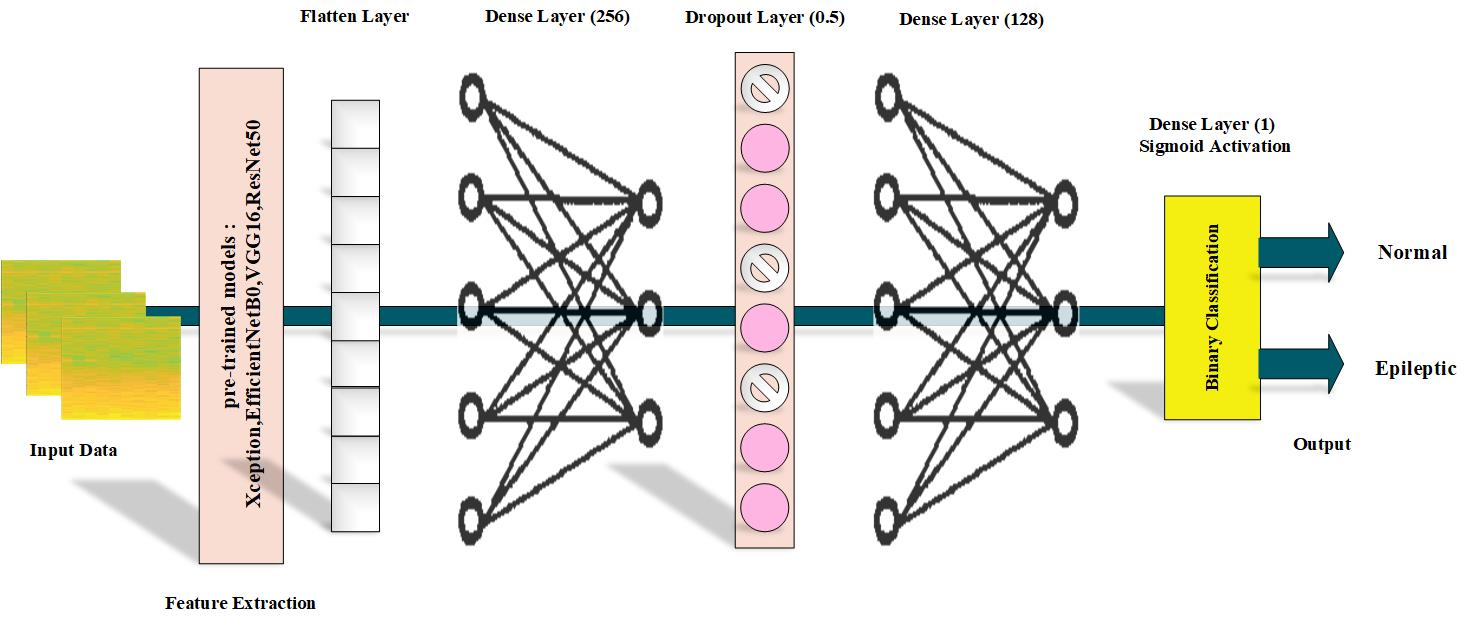

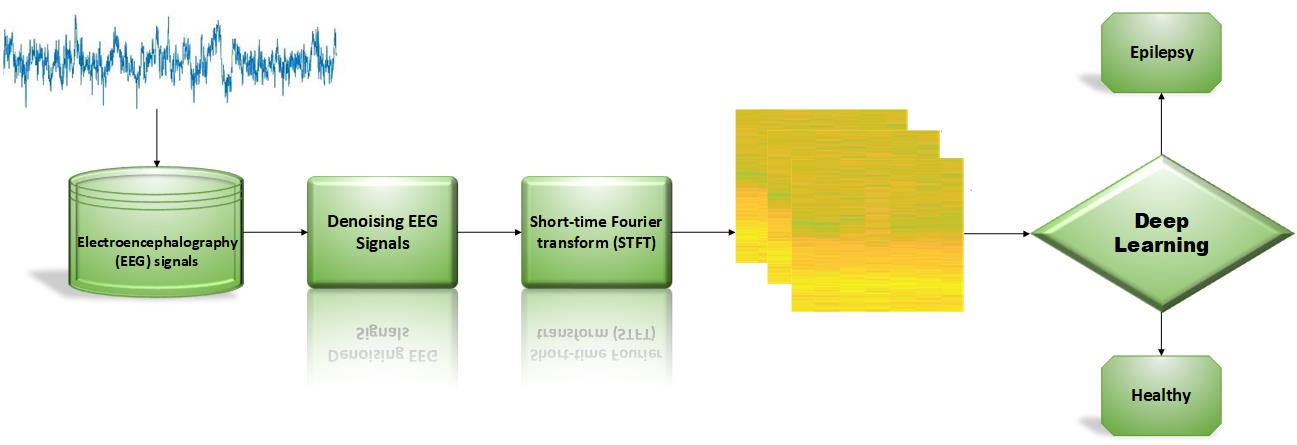